In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

db_path = 'puzzles.db'
conn = sqlite3.connect(db_path)

In [ ]:
query = "SELECT length FROM solutions;"
df = pd.read_sql_query(query, conn)

length_counts = df['length'].value_counts().sort_index()

In [ ]:
plt.figure(figsize=(12, 6))

total = length_counts.sum()
length_percent = (length_counts / total) * 100

bars = plt.bar(length_percent.index, length_percent.values)  # type: ignore

plt.title(f'Распределение длин решений (всего {total} решений)', pad=20, fontsize=14)
plt.xlabel('Длина решений (шаги)', fontsize=12, labelpad=10)
plt.ylabel('Процент решений (%)', fontsize=12, labelpad=10)
plt.grid(axis='y', alpha=0.75)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}%',
             ha='center', 
             va='bottom',
             fontsize=9)

plt.xticks(
    length_percent.index,
    fontsize=10
)

plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
cursor = conn.cursor()

cursor.execute('''
    SELECT elo FROM puzzles WHERE elo != 1000
''')

data = cursor.fetchall()
data = [i[0] for i in data]

print('Average:', np.average(data))

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)

ax = [ax1, ax2, ax3, ax4]
b = [10, 20, 40, 80]


for i in range(len(ax)):
    a = ax[i]
    bins = b[i]
    a.hist(data, bins=bins)
    a.set_title(f'По {bins} корзинам')

plt.suptitle('Распределение рейтингов задач')
fig.tight_layout()
fig.subplots_adjust(top=.88)

plt.show()

In [ ]:
cursor = conn.cursor()

cursor.execute('''
    SELECT 
        u.nickname,
        COUNT(p.userId) as play_count
    FROM users u
    LEFT JOIN played p ON p.userId = u.id
    GROUP BY u.id, u.nickname
    ORDER BY u.nickname;
''')

data = cursor.fetchall()

data = sorted(data, key=lambda d: d[1])

users = [i[0] for i in data]
puzzles = [i[1] for i in data]

plt.barh(users, puzzles)

plt.title('Число решенных задач')

plt.show()

pass

In [ ]:
import sqlite3
import matplotlib.pyplot as plt
import pandas as pd

def calculate_theme_value(upvotes, downvotes):
    """Calculate theme value using the formula (up-down)/(up+down)"""
    total = upvotes + downvotes
    if total == 0:
        return 0
    return (upvotes - downvotes) / total

# Connect to database
conn = sqlite3.connect('puzzles.db')  # Replace with your database path
cursor = conn.cursor()

# Define theme pairs
theme_pairs = [
    ('opening', 'opening_upvotes', 'opening_downvotes'),
    ('middlegame', 'middlegame_upvotes', 'middlegame_downvotes'),
    ('endgame', 'endgame_upvotes', 'endgame_downvotes'),
    ('zugzwang', 'zugzwang_upvotes', 'zugzwang_downvotes'),
    ('cleaning', 'cleaning_upvotes', 'cleaning_downvotes'),
    ('queenrace', 'queenrace_upvotes', 'queenrace_downvotes'),
    ('promotion', 'promotion_upvotes', 'promotion_downvotes')
]

# Create lists to store results
themes = []
positive_counts = []

cursor.execute('select count(*) from themes')
total = cursor.fetchone()[0]

# Process each theme pair
for theme_name, up_col, down_col in theme_pairs:
    # Calculate positive counts using SQL
    query = f"""
    SELECT COUNT(*) 
    FROM themes 
    WHERE ({up_col} - {down_col}) > 0 AND ({up_col} + {down_col}) > 0
    """
    
    cursor.execute(query)
    count = cursor.fetchone()[0]
    
    themes.append(theme_name)
    positive_counts.append(count)

# Sort both lists together based on counts in descending order
sorted_pairs = sorted(zip(themes, positive_counts), key=lambda x: x[1], reverse=True)
themes, positive_counts = zip(*sorted_pairs)

# Close database connection
conn.close()

# Create bar chart
plt.figure(figsize=(12, 6))
bars = plt.bar(themes, positive_counts)
plt.title('Count of Puzzles with Positive Theme Values (Sorted)')
plt.xlabel('Theme Types')
plt.ylabel('Number of Puzzles')

# Rotate x-labels for better readability
plt.xticks(rotation=45, ha='right')

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height/total*100)}%',
             ha='center', va='bottom')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

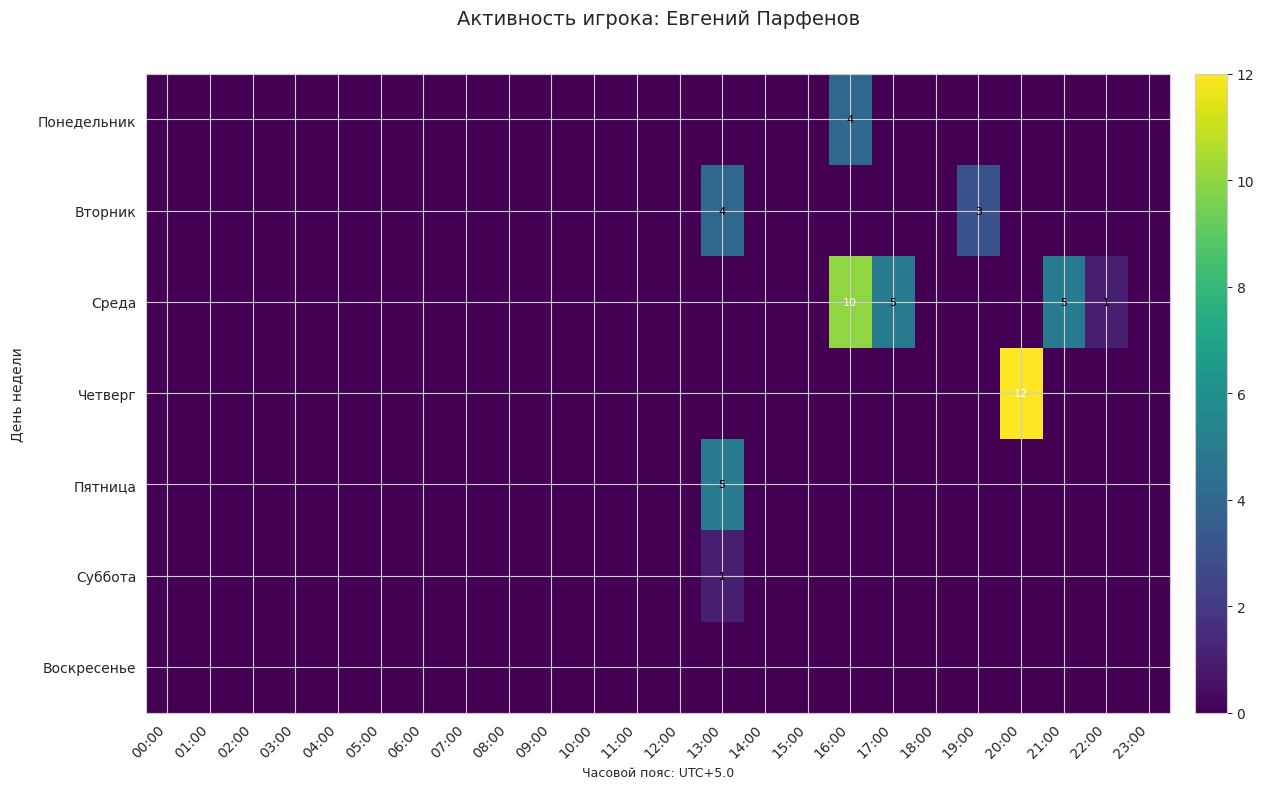

In [ ]:
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import datetime
import time
from matplotlib.ticker import FuncFormatter

# Параметры подключения к базе данных
DB_PATH = 'puzzles.db'  # Укажите путь к вашей базе данных
USER_ID = 0  # Замените на нужный ID игрока

# Подключение к базе данных
conn = sqlite3.connect(DB_PATH)
cursor = conn.cursor()

# Получение ника игрока
cursor.execute("SELECT nickname FROM users WHERE id = ?", (USER_ID,))
nickname_result = cursor.fetchone()
nickname = nickname_result[0] if nickname_result else f'Player {USER_ID}'

# Запрос данных о попытках (учитываем строковый формат даты)
query = """
    SELECT played.created_at 
    FROM played 
    WHERE userId = ? AND created_at != '0' AND created_at != ''
"""
cursor.execute(query, (USER_ID,))
timestamps = [row[0] for row in cursor.fetchall()]
conn.close()

# Определение локального часового пояса (без DST)
utc_offset = -time.timezone  # Смещение в секундах
local_tz = datetime.timezone(datetime.timedelta(seconds=utc_offset))

# Подготовка матрицы для сбора данных
activity_matrix = np.zeros((7, 24), dtype=int)  # 7 дней, 24 часа

# Обработка временных меток (строки в формате 'YYYY-MM-DD HH:MM:SS')
for ts_str in timestamps:
    try:
        # Парсинг строки как времени UTC
        utc_dt = datetime.datetime.strptime(ts_str, "%Y-%m-%d %H:%M:%S")
        utc_dt = utc_dt.replace(tzinfo=datetime.timezone.utc)
        
        # Конвертация в локальное время
        local_dt = utc_dt.astimezone(local_tz)
        
        # Определение дня недели и часа
        day = local_dt.weekday()  # 0=понедельник, 6=воскресенье
        hour = local_dt.hour
        activity_matrix[day, hour] += 1
    except (ValueError, TypeError):
        continue

# Создание heatmap
fig, ax = plt.subplots(figsize=(14, 8))
heatmap = ax.imshow(activity_matrix, cmap='viridis', aspect='auto')

# Настройка осей
days = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']
hours = [f'{h:02d}:00' for h in range(24)]

ax.set_xticks(np.arange(24))
ax.set_yticks(np.arange(7))
ax.set_xticklabels(hours, rotation=45, ha='right')
ax.set_yticklabels(days)

# Цветовая шкала
cbar = fig.colorbar(heatmap, ax=ax, pad=0.02)
cbar.formatter = FuncFormatter(lambda x, _: f'{int(x)}')
cbar.update_ticks()

# Заголовок и подписи
plt.title(f'Активность игрока: {nickname}\n', fontsize=14, pad=20)
plt.xlabel('Часовой пояс: UTC' + ('+' if utc_offset >= 0 else '') + f'{utc_offset/3600:.1f}', fontsize=9)
plt.ylabel('День недели', labelpad=10)

# Добавление значений в ячейки
for i in range(7):
    for j in range(24):
        count = activity_matrix[i, j]
        if count > 0:
            ax.text(j, i, count, ha='center', va='center', 
                    color='white' if count > np.max(activity_matrix)/2 else 'black',
                    fontsize=8)

plt.tight_layout()
plt.show()